## Image Classsification using TensorFlow on DSX

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

## Datasets 
    From http://yann.lecun.com/exdb/mnist/

### Loading the MNIST image datasets


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Explore the dataset
   https://dataplatform.ibm.com/analytics/notebooks/91440c8b-0bfb-471e-b04e-235e4d9f510d/view?access_token=fb4380415a903111e26cec3bd95d8ba91a04746185c866fecde9d36643fa5585

In [3]:
#https://gist.github.com/akesling/5358964

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

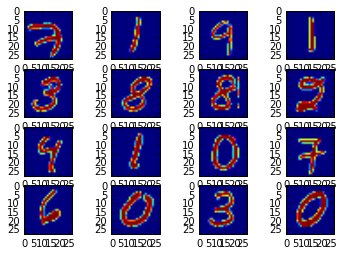

In [4]:
import matplotlib.pyplot as plt  
with tf.Session() as sess:
    #access first image
    f, axarr = plt.subplots(4,4)
    for i in range(16):
        j = i%4
        my_image = mnist.train.images[i]
        my_image = np.array(my_image, dtype='float')
        pixels = my_image.reshape((28, 28))
        axarr[j,i/4].imshow(pixels)
    plt.show()

## Multi-class Logistic Regression or Softmax Regression

Softmax function can be used to implement the Logistic regression for multiclass in **softmax regression (SMR)**, we replace the sigmoid logistic function and define Optimization to minimize error using **cross entropy**

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
image_url="https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/faq/softmax_regression/logistic_regression_schematic.png"
Image(url= image_url)

### Softmax function is defined as follow

In [6]:
image_url="https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/faq/softmax_regression/1.png"
Image(url = image_url)

### utility function to print confusion matrix for multiclass

In [ ]:
#https://stackoverflow.com/questions/35756710/how-do-i-create-confusion-matrix-of-predicted-and-ground-truth-labels-with-tenso

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

def print_confusion_matrix(plabels,tlabels):
    """
    functions print the confusion matrix for the different classes
    to find the error...

    Input:
    -----------
    plabels: predicted labels for the classes...
    tlabels: true labels for the classes

    code from: http://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    """
    import pandas as pd
    plabels = pd.Series(plabels)
    tlabels = pd.Series(tlabels)

    # draw a cross tabulation...
    df_confusion = pd.crosstab(tlabels,plabels, rownames=['Actual'], colnames=['Predicted'], margins=True)

    #print df_confusion
    return df_confusion

def confusionMatrix(text,Labels,y_pred, not_partial):
    y_actu = np.where(Labels[:]==1)[1]
    df = print_confusion_matrix(y_pred,y_actu)
    print("\n",df)
    #print plt.imshow(df.as_matrix())
    if not_partial:
        print("\n",classification_report(y_actu, y_pred))
    print("\n\t------------------------------------------------------\n")

def do_eval(message, sess, correct_prediction, accuracy, pred, X_, y_,x,y):
    predictions = sess.run([correct_prediction], feed_dict={x: X_, y: y_})
    prediction  = tf.argmax(pred,1)
    labels = prediction.eval(feed_dict={x: X_, y: y_}, session=sess)
    print(message, accuracy.eval({x: X_, y: y_}),"\n")
    confusionMatrix("Partial Confusion matrix",y_,predictions[0], False)#Partial confusion Matrix
    confusionMatrix("Complete Confusion matrix",y_,labels, True) #complete confusion Matrix


###  Tensorflow Session for model building

In [ ]:
#References:
#https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/logistic_regression.py
#https://github.com/aymericdamien/TensorFlow-Examples/

# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax 

# Minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    do_eval("Accuracy of Gold Test set Results: ", sess, correct_prediction, accuracy, pred, mnist.test.images, mnist.test.labels, x, y)
    
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))
   
    


Epoch: 0001 cost= 1.184097082
Epoch: 0002 cost= 0.665342004
Epoch: 0003 cost= 0.552860773
Epoch: 0004 cost= 0.498687588
Epoch: 0005 cost= 0.465492889
Epoch: 0006 cost= 0.442623399
Epoch: 0007 cost= 0.425522191
Epoch: 0008 cost= 0.412208776
Epoch: 0009 cost= 0.401384940
Epoch: 0010 cost= 0.392410288
Epoch: 0011 cost= 0.384807330
Epoch: 0012 cost= 0.378182560
Epoch: 0013 cost= 0.372422284
Epoch: 0014 cost= 0.367310899
Epoch: 0015 cost= 0.362725878
Epoch: 0016 cost= 0.358594379
Epoch: 0017 cost= 0.354845076
Epoch: 0018 cost= 0.351426914
Epoch: 0019 cost= 0.348350228
Epoch: 0020 cost= 0.345404039
Epoch: 0021 cost= 0.342792609
Epoch: 0022 cost= 0.340231078
Epoch: 0023 cost= 0.337932075


## Results
**Accuracy : 0.914** on test data